# Анализ пользовательского поведения в мобильном приложении.

# Цель проекта:

Разобраться, как ведут себя пользователи в нашем мобильном приложении по продаже продуктов питания.

# Описание проекта:

Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно? Исследуйте результаты A/A/B-эксперимента. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

## Загрузка исходных данных:

In [116]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from IPython.display import display
from scipy import stats as st
import re
from io import BytesIO
import requests
import math as mth

In [117]:
# загружаем данные и сохраняем в переменную:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [118]:
# Используем метод info чтобы изучить исходную информацию и найдём количество дубликатов:
df.info()
print('Количество дубликатов:', df.duplicated().sum())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Количество дубликатов: 413


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Вывод по исходным данным:

В исходных данных нет пропусков, но есть дубликаты - 413 штук. Так же стоит изменить формат для дат и переименовать столбцы.

## Подготовка данных к анализу:

In [119]:
# Переведем значения столбца EventTimestamp в формат даты и времени:
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'], unit='s')

In [120]:
# Переименуем названия столбцов:
df = df.rename(columns={
                    'EventName': 'event_name',
                    'DeviceIDHash': 'user_id',
                    'EventTimestamp': 'event_datetime',
                    'ExpId': 'group'
                        })
# Проверим, переименовались столбцы или нет:
df.columns

Index(['event_name', 'user_id', 'event_datetime', 'group'], dtype='object')

In [121]:
# Приведём все названия событий из столбца event_name к нижнему регистру
df['event_name'] = df['event_name'].str.lower()

In [122]:
# Выделим из столбца event_datetime дату и сохраним в отдельный столбец:
df['event_date'] = df['event_datetime'].dt.date

In [123]:
# Удалим дубликаты из наших данных:
df = df.drop_duplicates()

In [124]:
# Ещё раз используем метод info чтобы изучить исходную информацию и найдём количество дубликатов:
df.info()
print('Количество дубликатов:', df.duplicated().sum())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
event_name        243713 non-null object
user_id           243713 non-null int64
event_datetime    243713 non-null datetime64[ns]
group             243713 non-null int64
event_date        243713 non-null object
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB
Количество дубликатов: 0


,event_name,user_id,event_datetime,group,event_date
0,mainscreenappear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,mainscreenappear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,paymentscreensuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,cartscreenappear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,paymentscreensuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Вывод:

Данные готовы к анализу: привели дату со временем к нужному формату, переименовали столбцы, все названия событий привели к нижнему регистру и удалили дубликаты из наших данных.

## Изучим данные:

In [125]:
# Посчитаем, сколько всего событий:
events_qty = len(df['event_name'])
print('Всего событий в логе:', events_qty)

Всего событий в логе: 243713


In [126]:
# Посчитаем, сколько всего уникальных пользователей:
users_qty = len(df['user_id'].unique())
print('Всего пользователей в логе:', users_qty)

Всего пользователей в логе: 7551


In [127]:
# Посчитаем сколько в среднем событий приходится на пользователя:
avg_events_on_user = events_qty / users_qty
print('В среднем {:.0f} события/-ий приходится на пользователя.'.format(avg_events_on_user))

В среднем 32 события/-ий приходится на пользователя.


In [128]:
events_by_users = df.groupby('user_id')['event_name'].count().reset_index()
print('медиана равна', events_by_users['event_name'].median())
from statistics import mode
print('мода равна', mode(events_by_users['event_name'].values.tolist()))


медиана равна 20.0
мода равна 5


В нашем распределении среднее число событий на пользователя получилось 32, медианное значение 20, а мода равна 5. Мода представляет собой значение изучаемого признака, повторяющееся с наибольшей частотой, т.е. в нашем случае, чаще всего пользователи совершали 5 событий. Так как среднее значание получилось значительно больше медианы, значит есть пользователи, которые совершили очень много событий в наших данных.

In [129]:
# Минимальная дата в наших данных:
mid_date = df['event_date'].min()
print(mid_date)

2019-07-25


In [130]:
# Максимальная дата в наших данных:
max_date = df['event_date'].max()
print(max_date)

2019-08-07


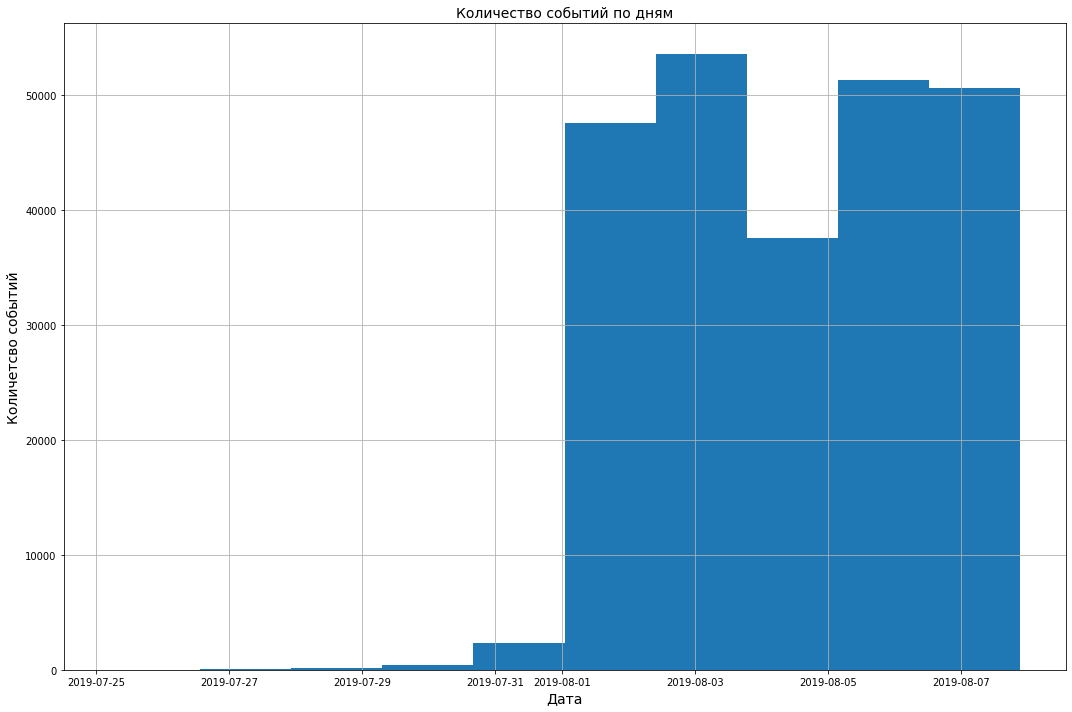

In [131]:
# Строим гистограмму по дате и времени, посмотрим сколько событий было в каждый из дней:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df['event_datetime'].hist(figsize=(15,10))
plt.title('Количество событий по дням', fontsize=14)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количетсво событий', fontsize=14)
plt.tight_layout()

По гистограмме хорошо видно, где начинаются дни с полными данными по всем событиям. Полные данные представлены с 1го августа включительно.

In [132]:
# Сделаем срез в данных и оставим данные только от 1го августа включительно:
df = df[df['event_datetime'] >= '2019-08-01']

In [133]:
# Посчитаем, сколько событий осталось после того, как мы отбросили старые данные:
events_qty_without_old_data = len(df['event_name'])
print('Всего событий в логе после отсечения старых данных:', events_qty_without_old_data)

Всего событий в логе после отсечения старых данных: 240887


In [134]:
# Посчитаем, сколько уникальных пользователей осталось после того, как мы отбросили старые данные:
users_qty_without_old_data = len(df['user_id'].unique())
print('Всего пользователей в логе после отсечения старых данных:', users_qty_without_old_data)

Всего пользователей в логе после отсечения старых данных: 7534


In [135]:
# Посчитаем, сколько событий мы потеряли, отбросив старые данные:
number_of_events_lost = events_qty - events_qty_without_old_data
print('Количетсво событий, удалённых после отсечения старых данных:', number_of_events_lost)
print(
    'Количетсво событий, удалённых после отсечения старых данных, относительно исходных данных: {:.2%}'\
      .format(number_of_events_lost / events_qty)
)

Количетсво событий, удалённых после отсечения старых данных: 2826
Количетсво событий, удалённых после отсечения старых данных, относительно исходных данных: 1.16%


In [136]:
# Посчитаем, сколько пользователей мы потеряли, отбросив старые данные:
number_of_users_lost = users_qty - users_qty_without_old_data
print('Количетсво пользователей, удалённых после отсечения старых данных:', number_of_users_lost)
print(
    'Количетсво пользователей, удалённых после отсечения старых данных, относительно исходных данных: {:.2%}'\
      .format(number_of_users_lost / users_qty)
)

Количетсво пользователей, удалённых после отсечения старых данных: 17
Количетсво пользователей, удалённых после отсечения старых данных, относительно исходных данных: 0.23%


In [137]:
# Проверим, что у нас есть пользователи из всех трёх экспериментальных групп:
df.groupby('group')['user_id'].agg({'nunique', 'count'})

,count,nunique
group,,
246,79302,2484
247,77022,2513
248,84563,2537


### Вывод:

В данной части нашего проекта мы посчитали сколько в среднем событий приходится на одного клиента. Установили по графику с какого периода у нас начинаются полные данные. Очистили наши исходные данные, отбросив данные, которые не попали в рассматриваемый период. Посчитали сколько событий и пользователей удалилось из данных - получили довольно небольшие значения: мы потеряли 1.16% событий и 0.23% клиентов относительно исходных данных. В получившихся данных все события попадают в три экспериментальные группы.

## Изучим воронку событий:

In [138]:
# Сгруппируем исходные данные по название событий и посчитаем их количество:
df_by_events = df.groupby('event_name')['user_id'].count().reset_index()

In [139]:
# посчитаем отношение каждого события к общему числу событий:
df_by_events['ratio'] = df_by_events['user_id'] / len(df)
df_by_events = df_by_events.sort_values(by='ratio', ascending=False) # сортируем по убыванию
df_by_events.reset_index(inplace = True, drop=True) # замена порядка индексов в таблице
df_by_events 

,event_name,user_id,ratio
0,mainscreenappear,117328,0.487067
1,offersscreenappear,46333,0.192343
2,cartscreenappear,42303,0.175613
3,paymentscreensuccessful,33918,0.140805
4,tutorial,1005,0.004172


In [140]:
# Посчитаем, сколько пользователей совершали каждое из этих событий:
events_by_uniq_users = df.groupby('event_name')['user_id'].nunique()\
    .reset_index().sort_values(by='user_id', ascending=False)
events_by_uniq_users.reset_index(inplace = True, drop=True) # замена порядка индексов в таблице
events_by_uniq_users

,event_name,user_id
0,mainscreenappear,7419
1,offersscreenappear,4593
2,cartscreenappear,3734
3,paymentscreensuccessful,3539
4,tutorial,840


In [141]:
# Посчитаем количетсво уникальных пользователей в исходных данных и сохраним в переменную:
uniq_users = df['user_id'].nunique()
uniq_users

7534

In [142]:
# Добавим столбец, в котором посчитаем долю пользователей, которые хоть раз совершали событие:
events_by_uniq_users['cr'] = events_by_uniq_users['user_id'] / uniq_users
events_by_uniq_users = events_by_uniq_users.rename(columns={'user_id':'users_count'}) # переименуем столбец
events_by_uniq_users

,event_name,users_count,cr
0,mainscreenappear,7419,0.984736
1,offersscreenappear,4593,0.609636
2,cartscreenappear,3734,0.495620
3,paymentscreensuccessful,3539,0.469737
4,tutorial,840,0.111495


Из выше перечисленных событий, скорее всего, только tutorial не будет входить в воронку событий: так как не все пользователи обращаются за инструкциями как оформить и оплатить заказ.
Наша воронка событий в этой случае будет выглядеть следующем образом:
mainscreenappear -> offersscreenappear -> cartscreenappear -> paymentscreensuccessful

In [143]:
# Удалим из нашей таблицы строку с событием tutorial, как не входящую в нашу воронку:
events_by_uniq_users = events_by_uniq_users.drop([4])
events_by_uniq_users

,event_name,users_count,cr
0,mainscreenappear,7419,0.984736
1,offersscreenappear,4593,0.609636
2,cartscreenappear,3734,0.495620
3,paymentscreensuccessful,3539,0.469737


In [144]:
# Применим метод pct_change(), который возвращает в % изменение ко следующему этапу.
# Так как у нас с каждым шагом всё меньше пользователей,
# то метод pct_change() будет возвращать отрицательное значение в %. 
# Поэтому перед выражением с этим методом добавим "1 + " и в итоге получим долю пользователей,
# которая проходит на следующий шаг воронки:
events_by_uniq_users['cr_by_step'] = 1 + events_by_uniq_users.users_count.pct_change()

# Заполним первое значение единицей, так нет никакого события перед mainscreenappear:
events_by_uniq_users = events_by_uniq_users.fillna(1)  
events_by_uniq_users # вывод на экран

,event_name,users_count,cr,cr_by_step
0,mainscreenappear,7419,0.984736,1.000000
1,offersscreenappear,4593,0.609636,0.619086
2,cartscreenappear,3734,0.495620,0.812976
3,paymentscreensuccessful,3539,0.469737,0.947777


По столбцу cr_by_step можно сразу увидеть, что только 62% пользователей переходит от mainscreenappear к offersscreenappear. На этом шаге теряется больше всего пользователей (38%) в нашей воронке.

In [145]:
# Посчитаем долю пользователей, которые доходят от первого события до оплаты:
print('{:.2%}'.format(events_by_uniq_users['users_count'][3] / events_by_uniq_users['users_count'][0]))

47.70%


### Вывод:

По данному разделу можно сделать следующие выводы:
- самое популярное событие - mainscreenappear;
- воронка событий выглядит следующим образом:
    mainscreenappear -> offersscreenappear -> cartscreenappear -> paymentscreensuccessful;
- Больше всего пользователей (38%) теряется при переходе от mainscreenappear к offersscreenappear.
- Практически каждый второй пользователь (47.70%) из тех кто зашел на главную страницу, совершает и оплачивает заказ.

## Изучим результаты эксперимента:

In [146]:
# Сделаем отдельные таблицы из исходных данных для каждой группы:
group_246 = df[df['group'] == 246]
group_247 = df[df['group'] == 247]
group_248 = df[df['group'] == 248]

In [147]:
# Найдём число пользователей в каждой экспериментальной группе:
# Посчитаем количетсво уникальных пользователей в исходных данных и сохраним в переменную:
group_246_uniq_users = group_246['user_id'].nunique()
group_247_uniq_users = group_247['user_id'].nunique()
group_248_uniq_users = group_248['user_id'].nunique()
print('Количество уникальных пользователей в группе 246:', group_246_uniq_users)
print('Количество уникальных пользователей в группе 247:', group_247_uniq_users)
print('Количество уникальных пользователей в группе 248:', group_248_uniq_users)

Количество уникальных пользователей в группе 246: 2484
Количество уникальных пользователей в группе 247: 2513
Количество уникальных пользователей в группе 248: 2537


Количетсво пользователей в разных группах различается примерно на 1% - что удовлетворяет критериям успешного А/А теста.

In [148]:
# группируем по названию событий, считаем кол-во пол-ей и отсортируем по убыванию
group_246_by_events = group_246.groupby('event_name')['user_id']\
        .nunique().sort_values(ascending=False).reset_index()

# удалим из таблицы событие tutorial и переименуем столбец user_id:
group_246_by_events = group_246_by_events.drop([4]).rename(columns={'user_id':'users_count'})

# считаем отношение количества событий к количеству уникальных клиентов:
group_246_by_events['ratio'] = group_246_by_events['users_count'] / group_246_uniq_users

# вывод таблицы:
group_246_by_events

,event_name,users_count,ratio
0,mainscreenappear,2450,0.986312
1,offersscreenappear,1542,0.620773
2,cartscreenappear,1266,0.509662
3,paymentscreensuccessful,1200,0.483092


In [149]:
# группируем по названию событий, считаем кол-во пол-ей и отсортируем по убыванию
group_247_by_events = group_247.groupby('event_name')['user_id']\
        .nunique().sort_values(ascending=False).reset_index()

# удалим из таблицы событие tutorial и переименуем столбец user_id:
group_247_by_events = group_247_by_events.drop([4]).rename(columns={'user_id':'users_count'})

# считаем отношение количества событий к количеству уникальных клиентов:
group_247_by_events['ratio'] = group_247_by_events['users_count'] / group_247_uniq_users

# вывод таблицы:
group_247_by_events

,event_name,users_count,ratio
0,mainscreenappear,2476,0.985277
1,offersscreenappear,1520,0.604855
2,cartscreenappear,1238,0.492638
3,paymentscreensuccessful,1158,0.460804


In [150]:
# группируем по названию событий, считаем кол-во пол-ей и отсортируем по убыванию
group_248_by_events = group_248.groupby('event_name')['user_id']\
        .nunique().sort_values(ascending=False).reset_index()

# удалим из таблицы событие tutorial и переименуем столбец user_id:
group_248_by_events = group_248_by_events.drop([4]).rename(columns={'user_id':'users_count'})

# считаем отношение количества событий к количеству уникальных клиентов:
group_248_by_events['ratio'] = group_248_by_events['users_count'] / group_248_uniq_users

# вывод таблицы:
group_248_by_events

,event_name,users_count,ratio
0,mainscreenappear,2493,0.982657
1,offersscreenappear,1531,0.603469
2,cartscreenappear,1230,0.484825
3,paymentscreensuccessful,1181,0.465510


In [151]:
# Обернём проверку гипотезы о равенстве долей в функцию:
def z_value(successes_1, successes_2, trials_1, trials_2):
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([successes_1, successes_2])
    trials = np.array([trials_1, trials_2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

### Проверим, находят ли статистические критерии разницу между выборками 246 и 247:

- Сформулируем нулевую гипотезу:
Будем считать доли двух выборок равными, не имеющих различий.
- Сформулируем альтернативную гипотезу:
Доли двух выборок отличаются и имеют различия.

In [152]:
# Применим нашу функцию:
# В качестве успешных значений возьмём те, где количество пользователей на шаге mainscreenappear.
# В качестве попыток возьмём значения равные количетсву уникальных пользователей из этих групп 246 и 247.
z_value(
    group_246_by_events['users_count'][3],
    group_247_by_events['users_count'][3],
    group_246_by_events['users_count'][0],
    group_247_by_events['users_count'][0]
       )

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Сравним результаты двух групп (246 и 247) для самого популярного события:

Самым популярным событием для всех групп будет являться - mainscreenappear.

- Сформулируем нулевую гипотезу:
Будем считать доли двух выборок равными, не имеющих различий.
- Сформулируем альтернативную гипотезу:
Доли двух выборок отличаются и имеют различия.

In [153]:
# Применим нашу функцию:
# В качестве успешных значений возьмём те, где количество пользователей на шаге mainscreenappear.
# В качестве попыток возьмём значения равные количетсву уникальных пользователей из этих групп 246 и 247.
z_value(
    group_246_by_events['users_count'][0],
    group_247_by_events['users_count'][0],
    group_246_uniq_users,
    group_247_uniq_users
       )

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Сравним результаты двух групп (246 и 247) для всех событий:

In [154]:
# Чтобы сравнить результаты всех групп по всем событиям, запустим нашу функцию в цикле,
# в которой на вход будут подаваться номера индексов соответвующие каждому событию:
for i in list(group_246_by_events.index):
    z_value(
        group_246_by_events['users_count'][i],
        group_247_by_events['users_count'][i],
        group_246_uniq_users,
        group_247_uniq_users
           )

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Сравним результаты двух групп (246 и 248) для всех событий:

In [155]:
# Чтобы сравнить результаты всех групп по всем событиям, запустим нашу функцию в цикле,
# в которой на вход будут подаваться номера индексов соответвующие каждому событию:
for i in list(group_246_by_events.index):
    z_value(
        group_246_by_events['users_count'][i],
        group_248_by_events['users_count'][i],
        group_246_uniq_users,
        group_248_uniq_users
           )

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Сравним результаты двух групп (247 и 248) для всех событий:

In [156]:
# Чтобы сравнить результаты всех групп по всем событиям, запустим нашу функцию в цикле,
# в которой на вход будут подаваться номера индексов соответвующие каждому событию:
for i in list(group_247_by_events.index):
    z_value(
        group_247_by_events['users_count'][i],
        group_248_by_events['users_count'][i],
        group_247_uniq_users,
        group_248_uniq_users
           )

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Сравним результаты двух групп: 248 и объединённой из 246 и 247 для всех событий:

In [157]:
# Создадим объединённую группу, которая будет состоять из групп 246 и 247:
group_246_and_247 = df[(df['group'] == 246) | (df['group'] == 247)]

# группируем по названию событий, считаем кол-во пол-ей и отсортируем по убыванию
group_246_and_247_by_events = group_246_and_247.groupby('event_name')['user_id']\
        .nunique().sort_values(ascending=False).reset_index()

# удалим из таблицы событие tutorial и переименуем столбец user_id:
group_246_and_247_by_events = group_246_and_247_by_events.drop([4]).rename(columns={'user_id':'users_count'})

# считаем отношение количества событий к количеству уникальных клиентов:
group_246_and_247_by_events['ratio'] = group_246_and_247_by_events['users_count'] / group_246_and_247['user_id'].nunique()

# вывод таблицы:
group_246_and_247_by_events

,event_name,users_count,ratio
0,mainscreenappear,4926,0.985791
1,offersscreenappear,3062,0.612768
2,cartscreenappear,2504,0.501101
3,paymentscreensuccessful,2358,0.471883


In [158]:
# Чтобы сравнить результаты всех групп по всем событиям, запустим нашу функцию в цикле,
# в которой на вход будут подаваться номера индексов соответвующие каждому событию:
for i in list(group_248_by_events.index):
    z_value(
        group_246_and_247_by_events['users_count'][i],
        group_248_by_events['users_count'][i],
        group_246_and_247['user_id'].nunique(),
        group_248_uniq_users
           )

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Вывод:

В данном разделе мы провели 17 проверок статистических гипотез, в каждой из них мы выбрали уровень значимости равный 5%. Ни одна из проверок не дала отвергнуть гипотезу о том, что доли в группах равны. Если выбирать уровень значимости более 5%, то будем увеличивать вероятность получения ложного результата. При статистических исследованиях следует выбирать уровень значимости в пределах от 1 до 5%.

## Общий вывод по проекту:

На этапе обработки данных удалили 413 дубликатов, так же в данных присутствовали старые данные за июль, которые так же были отсеяны для оценки резульатов A/A/B теста. Всего за июль было удалено 1.16% событий и 0.23% клиентов относительно исходных данных. Значения столбца EventTimestamp были переведены в формат даты и времени.
В данном проекте мы исследовали воронку продаж, установили какие шаги в нее входят. 
Получилась следующая воронка: главный экран -> экран с предложением -> корзина -> успешная оплата.
Этап с инструкциями не входит в воронку, так как очень малое количество пользователей ими пользуется.
Около 47% всех пользователей совершают покупку. Больше всего пользователей (38%) теряется при переходе от главного экрана к экрану с предложением, возможно не у всех пользователей/не на всех устройствах показывается страница с предложением. Так же исследовав результаты A/A/B-эксперимента можно сделать вывод о том, что изменение шрифта никак не повлияло на конверсию на различных шагах воронки продаж. Нет никакого смысла обновлять шрифт.